<a href="https://colab.research.google.com/github/Pistolll/7rpak_tovii/blob/main/7prak%20TOVIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ART for TensorFlow v2 - Keras API

Этот код демонстрирует атаки и защиту нейросетей от adversarial-примеров (враждебных примеров) с помощью библиотеки ART (Adversarial Robustness Toolbox).
На примере MNIST и модели на TensorFlow/Keras

FGSM (Fast Gradient Sign Method) — это один из простейших и популярных методов создания adversarial-примеров (враждебных примеров).
Идея в том, чтобы немного искажать входные данные, добавляя шум в направлении градиента ошибки модели, чтобы заставить модель ошибиться.

FGSM вычисляет градиент функции потерь модели по входу.

Затем изменяет исходное изображение в сторону, которая максимально увеличивает ошибку (с шагом, контролируемым параметром eps).

Итог — небольшое изменение, почти незаметное глазу, но способное «обмануть» модел

In [1]:
!pip install -U numpy==1.23.5 scikit-learn==1.1.3 tensorflow==2.12.0 adversarial-robustness-toolbox==1.14.0

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer

# Проверка версии
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

# Загрузка MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Для ускорения теста
x_test = x_test[:100]
y_test = y_test[:100]


11490434/11490434 [==============================] - 0s 0us/step


Создаём обычную простую полносвязную нейросеть, обучаем её на MNIST и получаем хорошее качество на обычных данных. Эта модель потом будет использоваться как "базовая" — чтобы сравнить с защищённой.

In [3]:
# Создаём модель нейронной сети (базовую, без защиты)
model = tf.keras.models.Sequential([

    # Входной слой: принимает изображения 28x28 пикселей
    tf.keras.layers.InputLayer(input_shape=(28, 28)),

    # "Разворачивает" изображение в вектор из 784 элементов (28*28)
    tf.keras.layers.Flatten(),

    # Полносвязный слой на 128 нейронов с функцией активации ReLU
    tf.keras.layers.Dense(128, activation='relu'),

    # Dropout-слой отключает случайно 20% нейронов во время обучения (для борьбы с переобучением)
    tf.keras.layers.Dropout(0.2),

    # Выходной слой на 10 нейронов (по числу классов — цифры от 0 до 9), softmax — для получения вероятностей
    tf.keras.layers.Dense(10, activation='softmax')
])

# Компилируем модель:
# - оптимизатор Adam
# - функция потерь: sparse_categorical_crossentropy (используется, когда метки классов — это числа, а не one-hot векторы)
# - метрика оценки — точность (accuracy)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем модель на тренировочных данных x_train и y_train, в течение 3 эпох
model.fit(x_train, y_train, epochs=3)


Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 9s 157us/sample - loss: 0.2946 - accuracy: 0.9151
Epoch 2/3
60000/60000 [==============================] - 9s 154us/sample - loss: 0.1429 - accuracy: 0.9576
Epoch 3/3
60000/60000 [==============================] - 8s 137us/sample - loss: 0.1082 - accuracy: 0.9662


In [4]:
# Оцениваем точность базовой модели на "чистых" (не атакованных) тестовых данных
loss_test, accuracy_test = model.evaluate(x_test, y_test)

# Выводим точность в процентах с двумя знаками после запятой
print('Accuracy on clean test data: {:4.2f}%'.format(accuracy_test * 100))


Accuracy on clean test data: 100.00%


In [5]:
# Оборачиваем обученную модель в ART-классификатор (необходим для работы с библиотекой adversarial-атак)
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Создаём атаку FGSM (Fast Gradient Sign Method) с параметром eps=0.3 (сила искажения)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)

# Генерируем атакованные (adversarial) примеры из исходных тестовых данных
x_test_adv = attack_fgsm.generate(x_test)

# Оцениваем модель на атакованных данных
loss_test_adv, accuracy_test_adv = model.evaluate(x_test_adv, y_test)

# Вычисляем среднее искажение — насколько сильно атакованные изображения отличаются от оригинальных
perturbation = np.mean(np.abs((x_test_adv - x_test)))

# Выводим точность модели на атакованных данных и среднее искажение
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_adv * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))


Accuracy on adversarial test data: 0.00%
Average perturbation: 0.18


Accuracy = 0.00% — модель полностью провалила классификацию на атакованных изображениях.

Это значит, что все 100 из 100 изображений она распознала неправильно, хотя до этого на чистых данных точность была ≈100%.

Average perturbation = 0.18 — средняя разница между исходными и атакованными изображениями составляет 18% от полного диапазона значений пикселей (0–1).
То есть визуально изменения незаметны, но для модели они критичны.

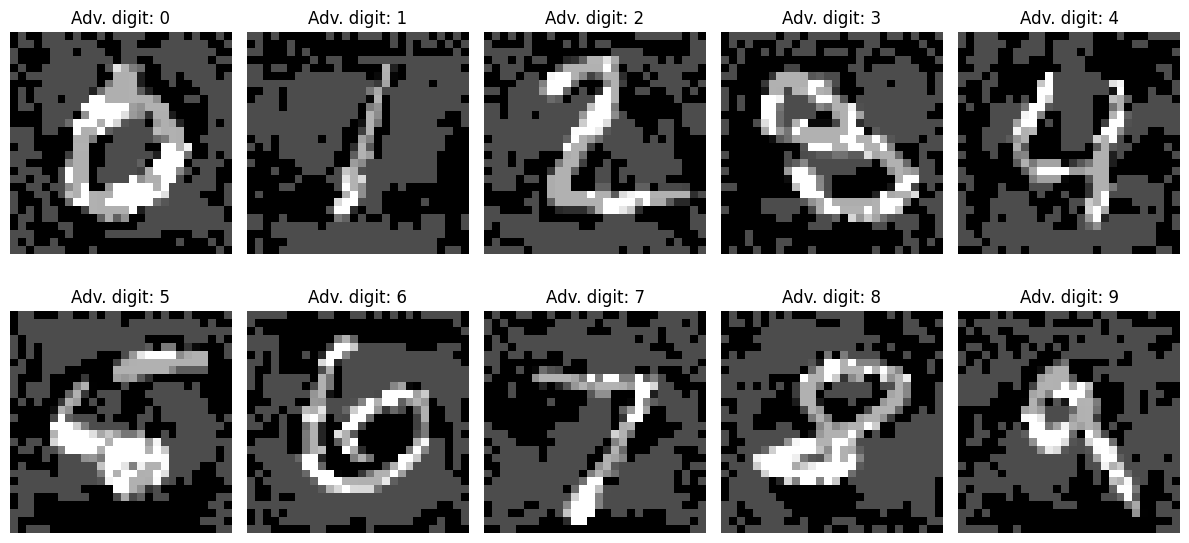

In [6]:
# Создаём словарь, в который запишем по одной атакованной картинке на каждую цифру (0–9)
unique_digits = {}
for i in range(len(x_test)):
    label = y_test[i]  # Истинная метка (цифра)
    if label not in unique_digits:
        # Если для этой цифры ещё нет картинки — добавляем первую попавшуюся атакованную
        unique_digits[label] = x_test_adv[i]
    if len(unique_digits) == 10:
        break  # Прекращаем цикл, как только собраны все 10 цифр

# Отображаем 10 атакованных изображений (по одной для каждой цифры от 0 до 9)
plt.figure(figsize=(12, 6))
for i, digit in enumerate(sorted(unique_digits)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(unique_digits[digit], cmap='gray')  # Серый цвет, как для рукописных цифр
    plt.title(f"Adv. digit: {digit}")  # Подпись – какая цифра это должна быть
    plt.axis('off')
plt.tight_layout()
plt.show()



Мы видим здеся по одной атакованной картинке для каждой цифры от 0 до 9.

Эти изображения получены после применения FGSM-атаки (с искажением eps=0.3) на x_test.

Важно: подписи (Adv. digit: X) — это настоящие метки, т.е. что было на самом деле до атаки.
Но модель на них ошибается, точность у неё была 0%.

In [7]:
model_defended = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Компилируем модель: оптимизатор Adam, функция потерь - кросс-энтропия, метрика - точность
model_defended.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Оборачиваем модель в классификатор ART — для использования adversarial training и атак
classifier_defended = KerasClassifier(model=model_defended, clip_values=(0, 1))

# Создаём FGSM-атаку, которую будем использовать во время adversarial training
attack_for_training = FastGradientMethod(estimator=classifier_defended, eps=0.3)

# Создаём объект AdversarialTrainer с долей adversarial-примеров 50% (ratio=0.5)
trainer = AdversarialTrainer(classifier=classifier_defended,
                             attacks=attack_for_training,
                             ratio=0.5)

# Запускаем обучение защищённой модели с adversarial training
trainer.fit(x_train, y_train, nb_epochs=3, batch_size=64)


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Модель обучена с учетом атак — теперь должна лучше справляться с adversarial примерами.

In [8]:
# Генерация новой атаки на защищённую модель
attack_fgsm_def = FastGradientMethod(estimator=classifier_defended, eps=0.3)
x_test_adv_def = attack_fgsm_def.generate(x_test)

# Оценка защищённой модели
loss_clean, acc_clean_def = model_defended.evaluate(x_test, y_test, verbose=0)
loss_adv, acc_adv_def = model_defended.evaluate(x_test_adv_def, y_test, verbose=0)

print(f"\n[Защита] Точность на обычных данных: {acc_clean_def * 100:.2f}%")
print(f"[Защита] Точность на атакованных данных: {acc_adv_def * 100:.2f}%")



[Защита] Точность на обычных данных: 99.00%
[Защита] Точность на атакованных данных: 59.00%


Модель model_defended отлично распознаёт обычные (неатакованные) изображения.

Модель model_defended устояла против FGSM-атаки на 59% изображений.

In [9]:
print("\n=== Сравнение точностей ===")
print(f"Без защиты — чистые данные:        {accuracy_test * 100:.2f}%")
print(f"Без защиты — атакованные данные:   {accuracy_test_adv * 100:.2f}%")
print(f"С защитой  — чистые данные:        {acc_clean_def * 100:.2f}%")
print(f"С защитой  — атакованные данные:   {acc_adv_def * 100:.2f}%")



=== Сравнение точностей ===
Без защиты — чистые данные:        100.00%
Без защиты — атакованные данные:   0.00%
С защитой  — чистые данные:        99.00%
С защитой  — атакованные данные:   59.00%


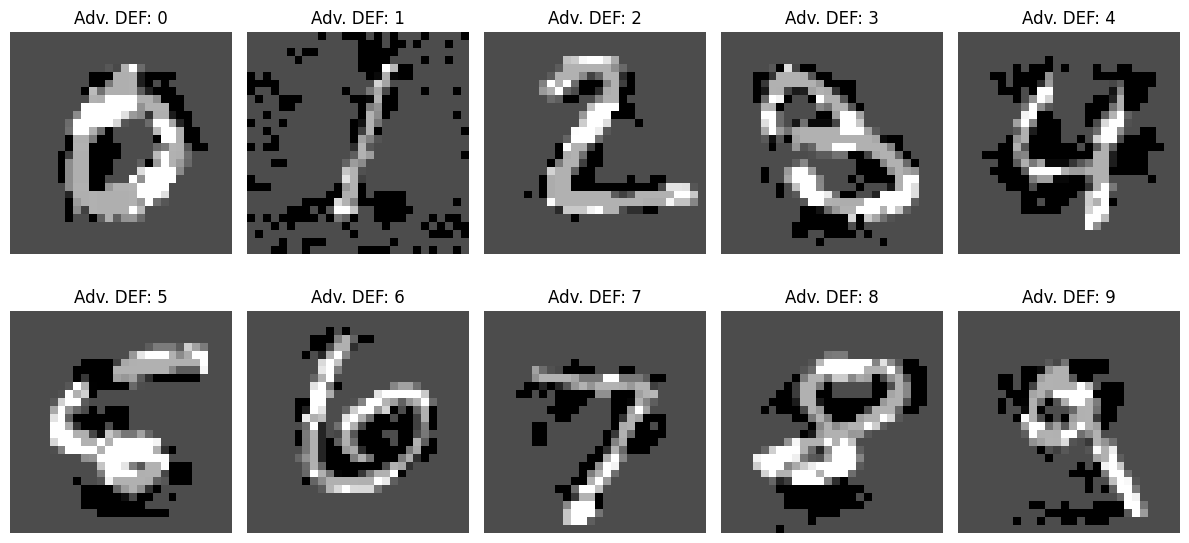

In [10]:
# Словарь для отображения уникальных цифр после атаки на защищённую модель
unique_digits_def = {}
for i in range(len(x_test)):
    label = y_test[i]
    if label not in unique_digits_def:
        unique_digits_def[label] = x_test_adv_def[i]
    if len(unique_digits_def) == 10:
        break

# Отображение
plt.figure(figsize=(12, 6))
for i, digit in enumerate(sorted(unique_digits_def)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(unique_digits_def[digit], cmap='gray')
    plt.title(f"Adv. DEF: {digit}")
    plt.axis('off')
plt.tight_layout()
plt.show()
